In [1]:
import sys
import time
import timeit

import scipy as sp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
sys.path.append('../src')
from propensity_score_match import get_features, get_labels, get_metadata
from faers_processor import save_json, load_json, generate_file_md5, save_object, load_object

# Load Data

In [3]:
dataset_info = load_json('../data/faers/drug/datasets/drug_2004-2004/dataset.json')

# Load "features" - other drugs and indications
features = get_features(dataset_info, 
                        feature_method='droprare', 
                        dataset_path='../data/faers/drug/datasets/drug_2004-2004/',
                        droprare_min=10)
print(features.shape, features.getnnz(), features.getnnz()/(features.shape[0]*features.shape[1]))
print()
# Load "labels" - ingredient, route exposures
labels, colnames = get_labels(dataset_info, 
                              dataset_path='../data/faers/drug/datasets/drug_2004-2004/',
                              exposed_min=10)
print(labels.shape, labels.getnnz(), labels.getnnz()/(labels.shape[0]*labels.shape[1]))
print()
reports = get_metadata(dataset_info, dataset_path='../data/faers/drug/datasets/drug_2004-2004/')
print(reports.shape)

  Loading feature matrices from disk.
  Concatenating feature matrices into single matrix.
  Dropping columns without enough data.
    Reduced columns from 54310 to 4323, a 92.04% reduction.
(199818, 4323) 805017 0.0009319341113945961

  Loading labels matrix from disk.
  Removing examples with too few reports.
    Reduced columns from 5357 to 1640, a 69.39% reduction.
(199818, 1640) 414124 0.001263723158806221

  Loading report metadata from disk.
    199915 rows loaded, will resort to match labels and feature matrices.
(199818, 8)


# Function Definitions

In [4]:
# Methods for the basic linear regression model on all available features

def resample_examples(X, y, min_unexposed = 10_000):
    
    p = max(y.sum(), min_unexposed)/y.shape[0]
    mask = np.where(np.squeeze(np.asarray((y.T + np.random.binomial(1, p, y.shape[0])) > 0)))[0]
    
    return X[mask,:], y[mask], mask

def filter_features_by_tanimoto(X, y, min_t = 0, max_t = 0.4):
    intersection = (y.multiply(X)).sum(axis=0)
    union = y.sum() + X.sum(axis=0) - intersection
    tanimoto = intersection / union
    
    mask = np.where(np.squeeze(np.asarray(tanimoto > 0)) & np.squeeze(np.asarray(tanimoto < 0.4)))[0]
    
    return X[:,mask], mask

def evaluate_linear_method(features, labels, max_iters=50, show_progress=True):
    aurocs = list()
    xval_aurocs = list()
    models = list()
    if not show_progress:
        iterator = range(labels.shape[1])[:max_iters]
    else:
        iterator = tqdm(range(labels.shape[1])[:max_iters], bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    
    for i in iterator:
        i_features, i_labels, example_mask = resample_examples(features, labels[:,i])
        i_features, feature_mask = filter_features_by_tanimoto(i_features, i_labels, 0, 0.4)
        
        if len(feature_mask) == 0:
            continue

        i_labels = i_labels.toarray()

        lr = LinearRegression()
        lr.fit(i_features, i_labels)
        models.append(lr)

        aurocs.append(roc_auc_score(i_labels, lr.predict(i_features)))

        # this is time consuming and only used to evaluate overfitting
        # would not be used in actual model training
        xval_aurocs.append(cross_val_score(lr, i_features, i_labels, scoring='roc_auc', cv=2).mean())

    return models, aurocs, xval_aurocs


In [5]:
# Methods for the PCA-based model

def evaluate_pc_method(PCs, labels, max_iters=50, show_progress=True):
    aurocs = list()
    xval_aurocs = list()
    models = list()
    if not show_progress:
        iterator = range(labels.shape[1])[:max_iters]
    else:
        iterator = tqdm(range(labels.shape[1])[:max_iters], bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    
    for i in iterator:

        i_features, i_labels, example_mask = resample_examples(PCs, labels[:,i])

        if i_labels.sum() == 0:
            models.append(None)
            aurocs.append(np.NaN)
            xval_aurocs.append(np.NaN)
            continue

        i_labels = i_labels.toarray()

        lr = LinearRegression()
        lr.fit(i_features, i_labels)
        
        models.append( lr )
        aurocs.append(roc_auc_score(i_labels, lr.predict(i_features)))

        # this is time consuming and only used to evaluate overfitting
        # would not be used in actual model training
        xval_aurocs.append(cross_val_score(lr, i_features, i_labels, scoring='roc_auc', cv=2).mean())
    
    return models, aurocs, xval_aurocs

In [6]:
# Method to resample the unexposed to match exposed using the fitted propensity score model

def resample_using_model(lr, features, labels, nsamples = 100_000, nbins=100, min_unexposed=3, min_exposed=1, unexposed_exposed_ratio=3):
    
    # get trained PSM model and make predictions for all reports
    predictions = lr.predict(features).squeeze()
    
    # generate a boolean mask to identify exposed reports vs unexposed
    exposed_mask = np.squeeze((labels==1).A)
    nexposed = exposed_mask.sum()
    #print(nexposed)

    # identify the indexes that correspond to each group
    exposed_indexes = np.where(exposed_mask)[0]
    unexposed_indexes = np.where(~exposed_mask)[0]

    # build a kernel based on the exposed data (we want to match this distr.)
    kernel = sp.stats.gaussian_kde(predictions[exposed_indexes])
    counts, bins = np.histogram(kernel.resample(nsamples), bins=nbins)

    # perform the resampling
    unexposed_sample = np.array([], dtype=int)
    exposed_sample = np.array([], dtype=int)

    for i, lower_bound in enumerate(bins[:-1]):
        upper_bound = bins[i+1]
        in_bin = (lower_bound <= predictions) & (predictions < upper_bound)
        exposed_in_bin = in_bin & exposed_mask
        unexposed_in_bin = in_bin & ~exposed_mask

        if unexposed_in_bin.sum() < min_unexposed or exposed_in_bin.sum() < min_exposed:
            # too few samples for this bin, skipping
            continue
        else:
            #ntosample = int(np.round(unexposed_exposed_ratio*nexposed*counts[i]/nsamples))
            ntosample = int(unexposed_exposed_ratio*exposed_in_bin.sum())
            sampled = np.random.choice(np.where(unexposed_in_bin)[0], ntosample, replace=True)
            unexposed_sample = np.hstack([unexposed_sample, sampled])
            exposed_sample = np.hstack([exposed_sample, np.where(exposed_in_bin)[0]])
    
    return {
        "predictions": predictions, 
        "exposed_sample": exposed_sample, 
        "unexposed_sample": unexposed_sample, 
        "exposed_mask": exposed_mask
    }

In [7]:
# Plotting Helpers

def plot_auroc_hists(aurocs, xval_aurocs):
    plt.hist(aurocs, alpha=0.5, bins=10, label='Training AUROC')
    plt.hist(xval_aurocs, alpha=0.5, bins=10, label='Xval AUROC Estimate')
    plt.xlabel('AUROC')
    plt.ylabel('Count')
    plt.legend()
    sns.despine()

def plot_auroc_scatter(aurocs, xval_aurocs):
    plt.scatter(xval_aurocs, aurocs, c='black', alpha=0.2)
    plt.xlabel('Cross-val AUROC Estimate')
    plt.ylabel('Training AUROC')
    plt.xlim(0.4, 1.05)
    plt.ylim(0.4, 1.05)
    sns.despine()

def plot_ps_distributions_before_after(predictions, exposed_sample, unexposed_sample, exposed_mask):
    
    # plot to show new fits
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    # plt.title(f"{colnames[i]} AUROC={100*aurocs[i]:.2f}%")
    sns.kdeplot(predictions[~exposed_mask], fill=True, color='black', label=f'Unexposed N={(~exposed_mask).sum()}', common_norm=True)
    sns.kdeplot(predictions[exposed_mask], fill=True, color='r', label=f'Exposed N={exposed_mask.sum()}', common_norm=True)
    plt.legend()
    plt.xlabel('Propensity Score')
    sns.despine()

    plt.subplot(1,2,2)
    # plt.title(f"{colnames[i]} AUROC={100*aurocs[i]:.2f}%")
    sns.kdeplot(predictions[unexposed_sample], fill=False, color='black', label=f'Unexposed N={unexposed_sample.shape[0]}')
    sns.kdeplot(predictions[exposed_sample], fill=False, color='r', label=f'Exposed N={exposed_sample.shape[0]}')
    plt.hist(predictions[unexposed_sample], density=True, bins=10, color='black', alpha=0.4)
    plt.hist(predictions[exposed_sample], density=True, bins=10, color='red', alpha=0.4)
    plt.legend()
    plt.xlabel('Propensity Score')
    sns.despine()

# PCA, then Linear Regression
- Unexposed reports are downsampled to match the number of exposed reports or 10,000, whichever is greater
- Dimensionality is reduced using SVD to find the first k principal components
- NOTE: there's a _slight_ violation of the mean 0 assumption for PCA

There's a good explanation about the relationship between SVD and PCA on this page: https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

In [8]:
U, S, VT = sp.sparse.linalg.svds(features.astype(float), k=50)

In [9]:
print(f"U.shape = {U.shape}")
print(f"S.shape = {S.shape}")
print(f"VT.shape = {VT.shape}")

U.shape = (199818, 50)
S.shape = (50,)
VT.shape = (50, 4323)


In [10]:
# We can compute PCA by US or XV
PCs = (U @ sp.sparse.diags(S))
PCs2 = (features @ VT.T)
print(PCs.shape)
np.allclose(PCs2, PCs)

(199818, 50)


True

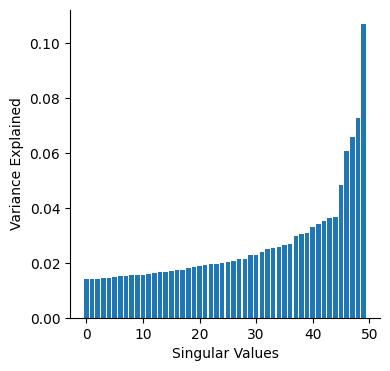

In [11]:
explained_variance = S**2/(features.shape[0]-1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance/total_var

plt.figure(figsize=(4,4))
plt.bar(range(len(S)), explained_variance)
plt.ylabel('Variance Explained')
plt.xlabel('Singular Values')
sns.despine()

### Use PCs to fit propensity score models

In [12]:
U, S, VT = sp.sparse.linalg.svds(features.astype(float), k=50)
PCs = (U @ sp.sparse.diags(S))
models, aurocs, xval_aurocs = evaluate_pc_method(PCs, labels, max_iters=labels.shape[1])

 31%|███       | 504/1640 [00:34<01:16, 14.88it/s]                                                                                                                                                                                                            /usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 384, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/usr/local/li

 70%|███████   | 1148/1640 [01:19<00:34, 14.13it/s]                                                                                                                                                                                                           /usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 384, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/usr/local/li

 98%|█████████▊| 1612/1640 [01:50<00:01, 15.02it/s]                                                                                                                                                                                                           /usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 384, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/usr/local/li

100%|█████████▉| 1634/1640 [01:52<00:00, 14.52it/s]                                                                                                                                                                                                           /usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 384, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/usr/local/li

100%|██████████| 1640/1640 [01:52<00:00, 14.58it/s]                                                                                                                                                                                                           


### Figure: Distribution of AUROCs for training and testing sets for PCA->linear regression

Using PCA to perform dimensionality reduction before fitting the linear regression model produces well calibrated models. The distirbutions of training AUROCs and cross-validation AUROCs are overlapping and highly correlated as is shown by the following figure. 

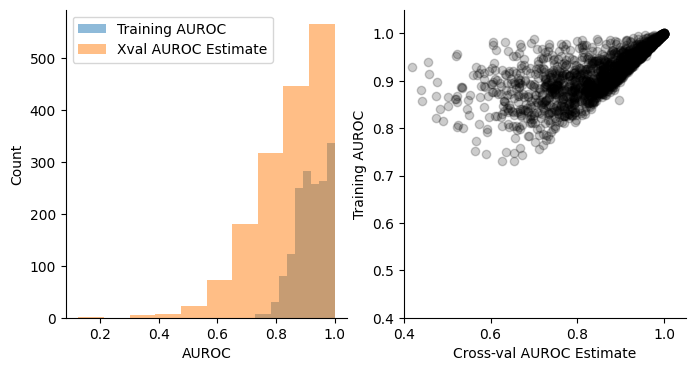

In [13]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_auroc_hists(aurocs, xval_aurocs)
plt.subplot(1,2,2)
plot_auroc_scatter(aurocs, xval_aurocs)

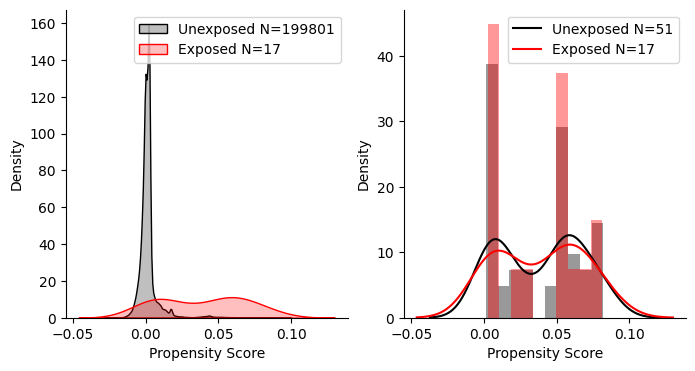

In [14]:
i = 1
match_data = resample_using_model(models[i], PCs, labels[:,i], nbins=100)
plot_ps_distributions_before_after(**match_data)

In [16]:
age_data = list()
sex_data = list()

for i in tqdm(range(labels.shape[1])[:200], bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    
    try:
        match_data = resample_using_model(models[i], PCs, labels[:,i], nbins=100)
    except Exception as e:
        continue
        
    exposed_age = reports[match_data['exposed_mask']]['patientonsetage'].mean()
    unexposed_age = reports[~match_data['exposed_mask']]['patientonsetage'].mean()
    
    unmatched_diff = exposed_age-unexposed_age
    
    matched_exposed_age = reports.iloc[match_data['exposed_sample']]['patientonsetage'].mean()
    matched_unexposed_age = reports.iloc[match_data['unexposed_sample']]['patientonsetage'].mean()
    
    matched_diff = matched_exposed_age-matched_unexposed_age
    
    exposed_pfemale = (reports[match_data['exposed_mask']]['patientsex']==2).mean()
    unexposed_pfemale = (reports[~match_data['exposed_mask']]['patientsex']==2).mean()
    unmatched_sex_diff = exposed_pfemale-unexposed_pfemale
    
    matched_exposed_pfemale = (reports.iloc[match_data['exposed_sample']]['patientsex']==2).mean()
    matched_unexposed_pfemale = (reports.iloc[match_data['unexposed_sample']]['patientsex']==2).mean()
    
    matched_sex_diff = matched_exposed_pfemale-matched_unexposed_pfemale
    
    #print(f"{i:3d}, {match_data['exposed_mask'].sum():5d}, {unmatched_diff:5.2f}, {matched_diff:5.2f}")
    age_data.append((i, match_data['exposed_mask'].sum(), unmatched_diff, matched_diff))
    sex_data.append((i, match_data['exposed_mask'].sum(), unmatched_sex_diff, matched_sex_diff))

100%|██████████| 200/200 [00:21<00:00,  9.40it/s]                                                                                                                                                                                                             


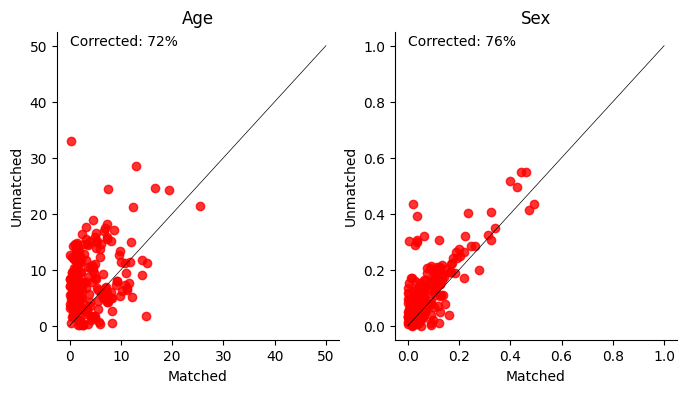

In [17]:
indexes, Ns, unmatched_diffs, matched_diffs = zip(*age_data)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.scatter(np.abs(matched_diffs), np.abs(unmatched_diffs), c='r', alpha=0.8)
plt.plot([0, 50], [0, 50], 'k-', lw=0.5)
plt.ylabel('Unmatched')
plt.xlabel('Matched')
pcloser = (np.abs(matched_diffs) < np.abs(unmatched_diffs)).sum()/len(matched_diffs)
plt.text(0, 50, f"Corrected: {100*pcloser:.0f}%")
plt.title('Age')
sns.despine()

indexes, Ns, unmatched_diffs, matched_diffs = zip(*sex_data)

plt.subplot(1,2,2)
plt.scatter(np.abs(matched_diffs), np.abs(unmatched_diffs), c='r', alpha=0.8)
plt.plot([0, 1], [0, 1], 'k-', lw=0.5)
plt.ylabel('Unmatched')
plt.xlabel('Matched')
pcloser = (np.abs(matched_diffs) < np.abs(unmatched_diffs)).sum()/len(matched_diffs)
plt.text(0, 1.0, f"Corrected: {100*pcloser:.0f}%")
plt.title('Sex')
sns.despine()

# Linear Regression
- Unexposed reports are downsampled to match the number of exposed reports or 10,000, whichever is greater
- Features are reduced to only those that co-occur with the drug exposure but ot too much

In [18]:
linear_models, linear_aurocs, linear_xval_aurocs = evaluate_linear_method(features, labels, max_iters=500)

100%|██████████| 500/500 [01:51<00:00,  4.49it/s]                                                                                                                                                                                                             


### Figure: Distribution of AUROCs for training and testing sets for linear regression

Linear regression produced overfit models as shown by the following figure. The difference in performance from the training set and the testing set is large. This will make using the PSM virtually impossible as all of the exposed samples will receive very large scores. We will need to address the overfitting problem before this approach can be used for PSM.

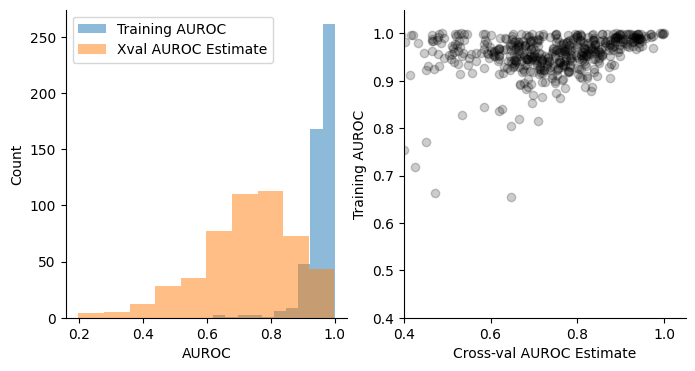

In [19]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_auroc_hists(linear_aurocs, linear_xval_aurocs)
plt.subplot(1,2,2)
plot_auroc_scatter(linear_aurocs, linear_xval_aurocs)

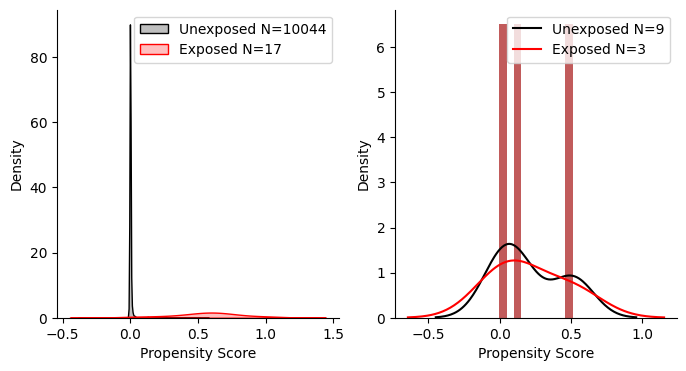

In [20]:
i = 1

i_features, i_labels, example_mask = resample_examples(features, labels[:,i])
i_features, feature_mask = filter_features_by_tanimoto(i_features, i_labels, 0, 0.4)

match_data = resample_using_model(linear_models[i], i_features, i_labels, nbins=100)
plot_ps_distributions_before_after(**match_data)

In [21]:
age_data = list()
sex_data = list()

for i in tqdm(range(labels.shape[1])[:200], bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    
    i_features, i_labels, example_mask = resample_examples(features, labels[:,i])
    i_features, feature_mask = filter_features_by_tanimoto(i_features, i_labels, 0, 0.4)
    
    try:
        match_data = resample_using_model(linear_models[i], i_features, i_labels, nbins=100)
    except Exception as e:
        continue
        
    exposed_age = reports.iloc[example_mask][match_data['exposed_mask']]['patientonsetage'].mean()
    unexposed_age = reports.iloc[example_mask][~match_data['exposed_mask']]['patientonsetage'].mean()
    
    unmatched_diff = exposed_age-unexposed_age
    
    matched_exposed_age = reports.iloc[example_mask].iloc[match_data['exposed_sample']]['patientonsetage'].mean()
    matched_unexposed_age = reports.iloc[example_mask].iloc[match_data['unexposed_sample']]['patientonsetage'].mean()
    
    matched_diff = matched_exposed_age-matched_unexposed_age
    #print(f"{i:3d}, {match_data['exposed_mask'].sum():5d}, {unmatched_diff:5.2f}, {matched_diff:5.2f}")
    
    exposed_pfemale = (reports.iloc[example_mask][match_data['exposed_mask']]['patientsex']==2).mean()
    unexposed_pfemale = (reports.iloc[example_mask][~match_data['exposed_mask']]['patientsex']==2).mean()
    unmatched_sex_diff = exposed_pfemale-unexposed_pfemale
    
    matched_exposed_pfemale = (reports.iloc[example_mask].iloc[match_data['exposed_sample']]['patientsex']==2).mean()
    matched_unexposed_pfemale = (reports.iloc[example_mask].iloc[match_data['unexposed_sample']]['patientsex']==2).mean()
    
    matched_sex_diff = matched_exposed_pfemale-matched_unexposed_pfemale
    
    
    age_data.append((i, match_data['exposed_mask'].sum(), unmatched_diff, matched_diff))
    sex_data.append((i, match_data['exposed_mask'].sum(), unmatched_sex_diff, matched_sex_diff))
    

100%|██████████| 200/200 [00:09<00:00, 20.41it/s]                                                                                                                                                                                                             


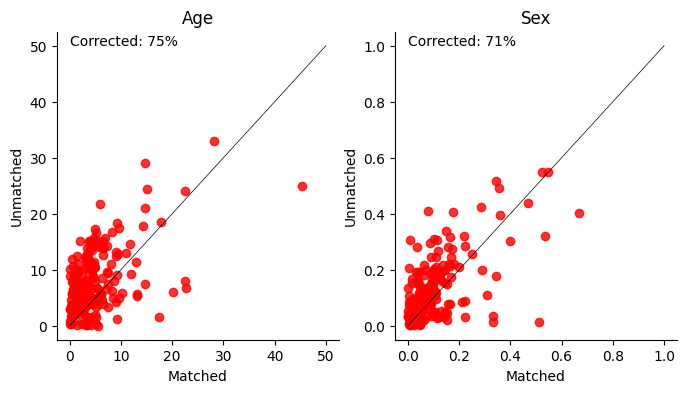

In [22]:
indexes, Ns, unmatched_diffs, matched_diffs = zip(*age_data)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.scatter(np.abs(matched_diffs), np.abs(unmatched_diffs), c='r', alpha=0.8)
plt.plot([0, 50], [0, 50], 'k-', lw=0.5)
plt.ylabel('Unmatched')
plt.xlabel('Matched')
pcloser = (np.abs(matched_diffs) < np.abs(unmatched_diffs)).sum()/len(matched_diffs)
plt.text(0, 50, f"Corrected: {100*pcloser:.0f}%")
plt.title('Age')
sns.despine()

indexes, Ns, unmatched_diffs, matched_diffs = zip(*sex_data)

plt.subplot(1,2,2)
plt.scatter(np.abs(matched_diffs), np.abs(unmatched_diffs), c='r', alpha=0.8)
plt.plot([0, 1], [0, 1], 'k-', lw=0.5)
plt.ylabel('Unmatched')
plt.xlabel('Matched')
pcloser = (np.abs(matched_diffs) < np.abs(unmatched_diffs)).sum()/len(matched_diffs)
plt.text(0, 1.0, f"Corrected: {100*pcloser:.0f}%")
plt.title('Sex')
sns.despine()